# 분류기(CLASSIFIER) 학습하기

### CIFAR10 데이터셋
- Classes : airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Shape : 3x32x32
    
<img src="./assets/cifar10.png" alt="cifar10"/>

## 이미지 분류기 학습하기

1. Dataset Load & Normalize
2. CNN
3. Loss Function
4. Train
5. Test

### 1. Dataset Load & Normalize

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
batch_size = 4

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


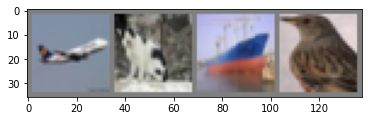

airplane   cat  ship  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # unnormalize
    img = img / 2 + 0.5

    # (channel, height, width)
    npimg_chw = img.numpy()

    # plt.imshow(x)에서 x의 shape는 (rows, columns, channels)이어야하므로,
    # np.transpose()로 (height, width, channels)로 맞춰줌
    npimg_whc = np.transpose(npimg_chw, (1, 2, 0))

    plt.imshow(npimg_whc)
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))


### 2. CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3. Loss Function

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train

In [6]:
print(len(trainset))

50000


In [7]:
num_epochs = 2

for epoch in range(num_epochs):

    running_loss = 0.0

    for i, data in enumerate(train_loader, 1):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 0:
            print("[%d, %5d] loss: %.3f" % (epoch, i, running_loss / 2000))
            running_loss = 0.0

print("Finish Training")

[0,  2000] loss: 2.210
[0,  4000] loss: 1.864
[0,  6000] loss: 1.684
[0,  8000] loss: 1.580
[0, 10000] loss: 1.538
[0, 12000] loss: 1.497
[1,  2000] loss: 1.409
[1,  4000] loss: 1.400
[1,  6000] loss: 1.360
[1,  8000] loss: 1.348
[1, 10000] loss: 1.296
[1, 12000] loss: 1.328
Finish Training


In [8]:
# 모델 저장
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

### 5. Test

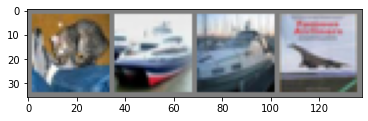

GroundTruth:    cat  ship  ship airplane


In [9]:
# 테스트 데이터 확인
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [10]:
images, labels = images.to(device), labels.to(device)

net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
# 출력 형태 확인
outputs = net(images)
print(outputs)

tensor([[-0.7834, -1.0831,  0.2335,  3.6887, -0.8778,  1.6641,  1.6676, -1.7212,
         -0.0203, -1.5901],
        [ 5.3445,  4.7596, -2.0054, -3.4243, -1.5228, -4.7900, -5.1678, -1.9169,
          3.2123,  4.2480],
        [ 1.7503,  2.8484, -0.7538, -0.6078, -1.4655, -2.1383, -2.4389, -1.6046,
          2.0335,  1.0265],
        [ 3.4071,  1.9760, -1.0497, -2.2480, -0.8684, -3.7473, -4.0858, -1.5108,
          4.8380,  0.8030]], device='cuda:0', grad_fn=<AddmmBackward>)


In [12]:
_, predicted = torch.max(outputs.data, 1)
print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

# predict한 indices
print(predicted)

Predicted:    cat airplane automobile  ship
tensor([3, 0, 1, 8], device='cuda:0')


In [13]:
# 전체 정답율 출력

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        total += batch_size
        correct += (labels == predicted).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * (correct / total)}%")


Accuracy of the network on the 10000 test images: 53.92%


In [14]:
# 각 클래스별 정답율 출력

class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)

        for i in range(batch_size):
            class_total[labels[i].item()] += 1
            class_correct[labels[i].item()] += int(c[i])
            

for i in range(10):
    print(f"Acuracy of {classes[i]} : {int(100 * (class_correct[i] / class_total[i]))}%")

Acuracy of airplane : 50%
Acuracy of automobile : 62%
Acuracy of bird : 47%
Acuracy of cat : 42%
Acuracy of deer : 35%
Acuracy of dog : 22%
Acuracy of frog : 76%
Acuracy of horse : 57%
Acuracy of ship : 76%
Acuracy of truck : 67%
